In [1]:
import numpy as np
import pandas as pd
import keras
import os
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Dense, LSTM, Dropout,Input,Embedding
from keras.applications.vgg19 import VGG19,preprocess_input
#from keras.applications.vgg16 import VGG16,preprocess_input
#from keras.applications.inception_v3 import InceptionV3,preprocess_input#299*299
#from keras.applications.resnet import ResNet50,Resnet101,preprocess_input#224*224
#from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input#299*299
from keras.models import Model
from keras.preprocessing.image import load_img,img_to_array
#from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import pandas as pd
import string
from collections import Counter
from copy import copy

Using TensorFlow backend.


In [2]:
def loadFile(flname):
    file=open(flname,'r')
    text=file.read()
    file.close()
    return text
flname="/home/ankit/data set/Flickr8k_text/Flickr8k.token.txt"
lemmatext=loadFile(flname)
#print(lemmatext)

In [3]:
def load_desc(lemmatext):
    intface=[]
    for line in lemmatext.split('\n'):
        word=line.split('\t')
        if len(line)<2:
            continue
        ids=word[0].split('#')
        intface.append(ids+[word[1].lower()])
        #ids=ids.split('.')[0]
        #desc=' '.join(desc)
        #if ids not in intface:
        #    intface[ids]=list()
        #intface[ids].append(desc)
        
    return intface
description=load_desc(lemmatext)
act_desc=pd.DataFrame(description,columns=["file","index","caption"])
filename=np.unique(act_desc.file.values)
#Counter(Counter(act_desc.file.values).values())
#description

In [4]:
def clean(description):
    descrip=description.translate(string.punctuation)
    descript=""
    for word in descrip.split():
        if len(word)>1:
            descript+=" "+word
    descriptions=""
    for word in descript.split():
        alpha=word.isalpha()
        if alpha:
            descriptions+=" "+word
    return(description)

In [5]:
for i,caption in enumerate(act_desc.caption.values):
    captions=clean(caption)
    #print(captions)
    act_desc["caption"].iloc[i]=captions
act_desc["caption"]

0        a child in a pink dress is climbing up a set o...
1                    a girl going into a wooden building .
2         a little girl climbing into a wooden playhouse .
3        a little girl climbing the stairs to her playh...
4        a little girl in a pink dress going into a woo...
5               a black dog and a spotted dog are fighting
6        a black dog and a tri-colored dog playing with...
7        a black dog and a white dog with brown spots a...
8        two dogs of different breeds looking at each o...
9          two dogs on pavement moving toward each other .
10       a little girl covered in paint sits in front o...
11       a little girl is sitting in front of a large p...
12       a small girl in the grass plays with fingerpai...
13       there is a girl with pigtails sitting in front...
14       young girl with pigtails painting outside in t...
15       a man lays on a bench while his dog sits by him .
16       a man lays on the bench to which a white dog i.

In [ ]:
act_desc

In [6]:
def start_end(cap):
    captions=[]
    for sentence in cap:
        sentence='startseq '+sentence+' endseq'
        captions.append(sentence)
    return(captions)
act_desc1=copy(act_desc)
act_desc1["caption"]=start_end(act_desc["caption"])
del act_desc
print(act_desc1["caption"])

0        startseq a child in a pink dress is climbing u...
1        startseq a girl going into a wooden building ....
2        startseq a little girl climbing into a wooden ...
3        startseq a little girl climbing the stairs to ...
4        startseq a little girl in a pink dress going i...
5        startseq a black dog and a spotted dog are fig...
6        startseq a black dog and a tri-colored dog pla...
7        startseq a black dog and a white dog with brow...
8        startseq two dogs of different breeds looking ...
9        startseq two dogs on pavement moving toward ea...
10       startseq a little girl covered in paint sits i...
11       startseq a little girl is sitting in front of ...
12       startseq a small girl in the grass plays with ...
13       startseq there is a girl with pigtails sitting...
14       startseq young girl with pigtails painting out...
15       startseq a man lays on a bench while his dog s...
16       startseq a man lays on the bench to which a wh.

In [7]:
model1=VGG19(weights='imagenet')
model=Model(model1.input,model1.layers[-2].output)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [8]:
images=os.listdir("/home/ankit/data set/Flickr8k_Dataset/Flicker8k_Dataset")



encoding={}
for x,img in enumerate(images):
    file="/home/ankit/data set/Flickr8k_Dataset/Flicker8k_Dataset"+"/"+img
    image=load_img(file, target_size=(224,224,3))
    image=img_to_array(image)
    pro_image=preprocess_input(image)
    features=model.predict(pro_image.reshape((1,)+pro_image.shape[:3]))
    #features=np.reshape(features,features.shape[1])
    encoding[img]=features.flatten()

In [9]:
imgs,indx=[],[]
act_desc1=act_desc1.loc[act_desc1["index"].values=="1",:]
for i,file in enumerate(act_desc1.file):
    if file in encoding.keys():
        imgs.append(encoding[file])
        indx.append(i)

files=act_desc1["file"].iloc[indx].values
capt=act_desc1["caption"].iloc[indx].values
capt
imgs=np.array(imgs)

In [10]:
tokens=Tokenizer(num_words=8000)
tokens.fit_on_texts(capt)
vocab_size=len(tokens.word_index)+1
texts=tokens.texts_to_sequences(capt)


In [11]:
train=int(len(texts)*.70)
def tra_test(text_image_file,train):
    return(text_image_file[:train],text_image_file[train:])
text_train,text_test=tra_test(texts,train)
imgs_train,imgs_test=tra_test(imgs,train)
files_train,files_test=tra_test(files,train)

In [12]:
maxlen=np.max([len(t) for t in texts])
def preprocess(texts,imgs):
    assert(len(texts)==len(imgs))
    Xtxt, Ximg, Ytxt=[],[],[]
    for txt,im in zip(texts,imgs):
        for i in range(1,len(txt)):
            in_txt,out_txt=txt[:i],txt[i]
            in_txt=pad_sequences([in_txt],maxlen=maxlen).flatten()
            out_txt=to_categorical(out_txt,num_classes=vocab_size)
            Xtxt.append(in_txt)
            Ximg.append(im)
            Ytxt.append(out_txt)
    Xtxt=np.array(Xtxt)
    Ximg=np.array(Ximg)
    Ytxt=np.array(Ytxt)
    return(Xtxt,Ximg,Ytxt)
Xtxt_train,Ximg_train,Ytxt_train=preprocess(text_train,imgs_train)

In [13]:
emb_dim=64

img_in=Input(shape=(Ximg_train.shape[1],))
layer_1=Dense(256,activation='relu',name="ImageFeature")(img_in)
txt_in=Input(shape=(maxlen,))
text_1=Embedding(vocab_size,emb_dim,mask_zero=True)(txt_in)
lstm_1=LSTM(256,name="CaptionFeature")(text_1)

Decode_1=layers.add([lstm_1,layer_1])
Decode_1=Dense(256,activation='relu')(Decode_1)
out=Dense(vocab_size,activation='softmax')(Decode_1)
model=Model(inputs=[img_in,txt_in],outputs=out)

model.compile(loss='categorical_crossentropy',optimizer='RMSprop')

In [14]:
training=model.fit([Ximg_train,Xtxt_train],Ytxt_train,epochs=15,verbose=1,batch_size=128)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
67853/67853 [==============================] - 132s 2ms/step - loss: 4.8359
Epoch 2/15
67853/67853 [==============================] - 138s 2ms/step - loss: 4.0711
Epoch 3/15
67853/67853 [==============================] - 138s 2ms/step - loss: 3.7944
Epoch 4/15
67853/67853 [==============================] - 138s 2ms/step - loss: 3.6528
Epoch 5/15
67853/67853 [==============================] - 138s 2ms/step - loss: 3.5533
Epoch 6/15
67853/67853 [==============================] - 138s 2ms/step - loss: 3.4870
Epoch 7/15
67853/67853 [==============================] - 139s 2ms/step - loss: 3.4329
Epoch 8/15
67853/67853 [==============================] - 140s 2ms/step - loss: 3.3945
Epoch 9/15
67853/67853 [==============================] - 137s 2ms/step - loss: 3.3589
Epoch 10/15
67853/67853 [==============================] - 136s 2ms/step - loss: 3.3360
Epoch 11/15
67853/67853 [==============================] - 138s 2ms/step - loss: 

In [15]:
ind_word=dict([(indx,word) for word,indx in tokens.word_index.items()])
def predict(img):
    in_text='startseq'
    for iword in range(maxlen):
        seq=tokens.texts_to_sequences([in_text])[0]
        seq=pad_sequences([seq],maxlen)
        y_pred=model.predict([img,seq],verbose=1);
        y_pred=np.argmax(y_pred)
        nword=ind_word[y_pred]
        in_text+=" "+nword
        if nword=="endseq":
            break
    return(in_text)


In [ ]:
count=1
fig=plt.figure(figsize=(10,20))
for filejpg, img_feat in zip(files_test[:10],imgs_test[:10]):
    img_file="/home/ankit/data set/Flickr8k_Dataset/Flicker8k_Dataset"+"/"+filejpg
    img_load=load_img(img_file,target_size=(224,224,3))
    ax=fig.add_subplot(10,2,count,xticks=[],yticks=[])
    ax.imshow(img_load)
    count+=1

    caption=predict(img_feat.reshape(1,len(img_feat)))
    caption=caption.split()
    caption=caption[1:-1]
    ax=fig.add_subplot(10,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count+=1
plt.show()

In [16]:
#ind_word=dict([(indx,word) for word,indx in tokens.word_index.items()])
from nltk.translate.bleu_score import sentence_bleu
good, bad, bleu=[],[],[]
count=0
for filesjpg,img_feat,token_txt in zip(files_test,imgs_test,text_test):
    count+=1
    true=[ind_word[i] for i in token_txt]
    true=true[1:-1]
    caption=predict(img_feat.reshape(1,len(img_feat)))
    caption=caption.split()
    caption=caption[1:-1]
    BLEU=sentence_bleu([true],caption)
    bleu.append(BLEU)
    if BLEU>0.7 and len(good)<5:
        good.append((BLEU,filesjpg,true,caption))
    elif BLEU<0.3 and len(bad)<5:
        bad.append((BLEU,filesjpg,true,caption))
        

/home/ankit/venv/lib/python3.5/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


1/1 [==============================] - 0s 7ms/step


/home/ankit/venv/lib/python3.5/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ankit/venv/lib/python3.5/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ankit/venv/lib/python3.5/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  

1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


good cap


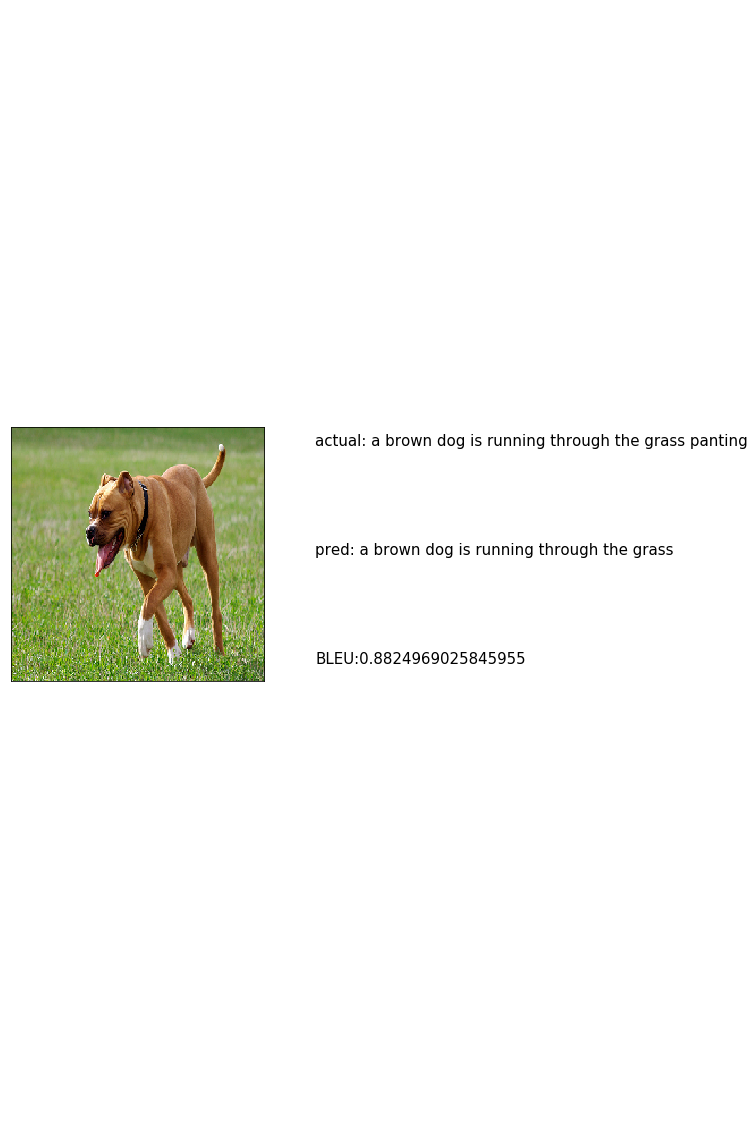

bad cap


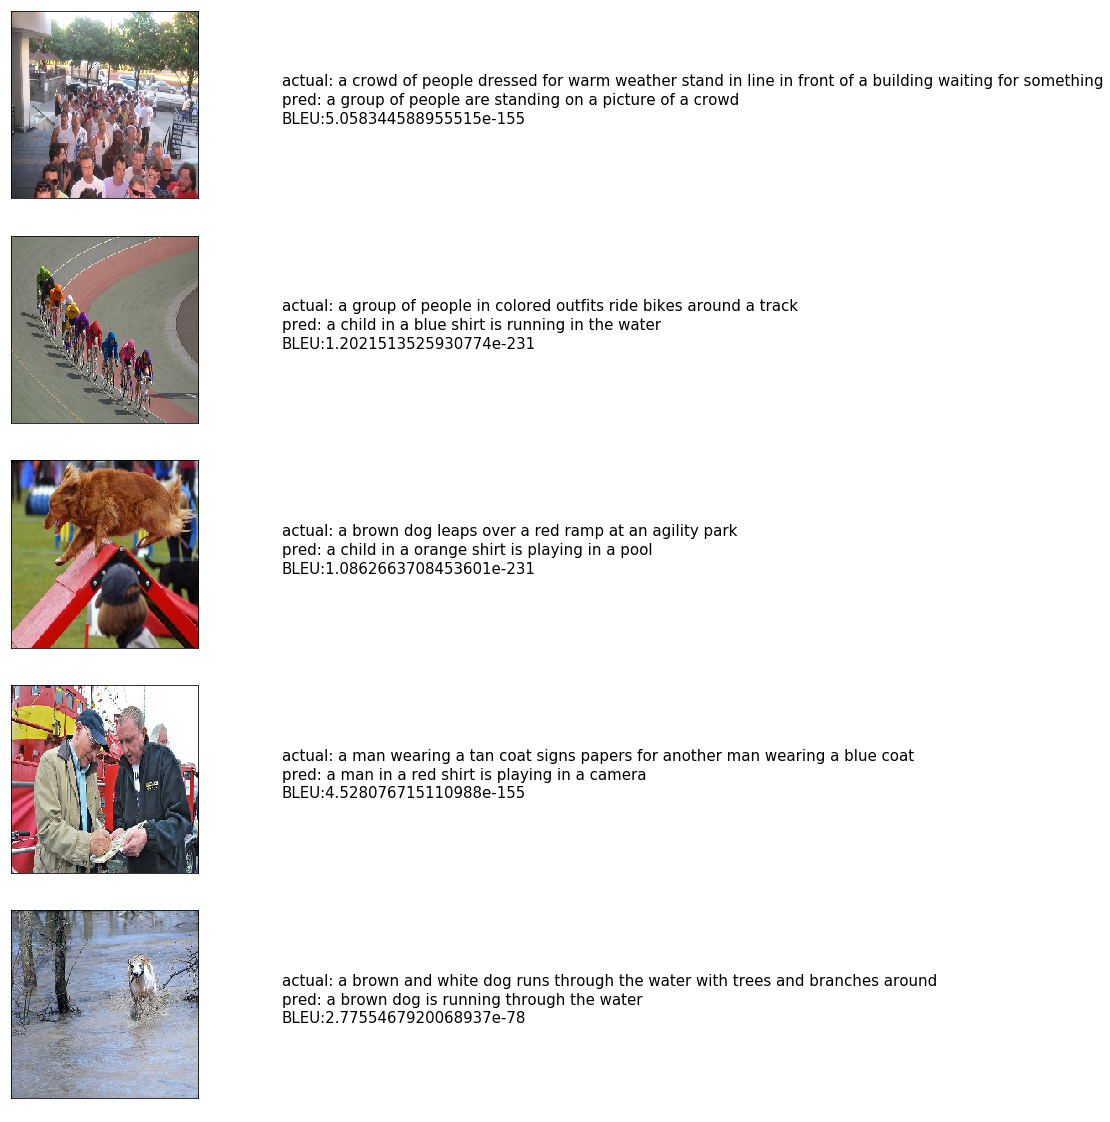

In [17]:
def good_bad(bad_good):
    def create_str(true):
        strue=""
        for s in true:
            strue+=" "+s
        return(strue)
    count=1
    fig=plt.figure(figsize=(10,20))
    for bg in bad_good:
        BLEU,filesjpg,true,caption=bg
        img_file="/home/ankit/data set/Flickr8k_Dataset/Flicker8k_Dataset"+"/"+filesjpg
        img_load=load_img(img_file,target_size=(224,224,3))
        ax=fig.add_subplot(len(bad_good),2,count,xticks=[],yticks=[])
        ax.imshow(img_load)
        count +=1
        
        true=create_str(true)
        caption=create_str(caption)
        ax=fig.add_subplot(len(bad_good),2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.6,"actual:"+true,fontsize=15)
        ax.text(0,0.5,"pred:"+caption,fontsize=15)
        ax.text(0,0.4,"BLEU:{}".format(BLEU),fontsize=15)
        count+=1
    plt.show()
print("good cap")
good_bad(good)
print("bad cap")
good_bad(bad)